In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from echoes import ESNRegressor
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
def shift_array(arr, n):
    # Shift the array by n positions
    shifted_arr = np.roll(arr, n)
    shifted_arr[:n] = 0

    return shifted_arr

def gen_lag_data(time_steps, random, max_lag):
    np.random.seed(random)
    x = np.random.uniform(-0.5, 0.5, time_steps)
    y = np.zeros((time_steps, max_lag))
    
    for lag in range(1, max_lag + 1):
        y[:, lag - 1] = shift_array(x, lag)
    return x, y

def compute_memory_capacity(connectivity_matrix, X_train, y_train, X_test, y_test, max_lag):
    total_memory_capacity = 0

    esn = ESNRegressor(
            spectral_radius=0.99,
            input_scaling=1e-6,
            leak_rate=1,
            bias=0,
            W=connectivity_matrix,
            random_state=42,
        )
    
    esn.fit(X_train, y_train)
    
    y_pred = esn.predict(X_test)
    
    for i in range(max_lag):
        true_values = y_test[:, i]
        predicted_values = y_pred[:, i]
        r, _ = pearsonr(true_values, predicted_values)
        r_squared = 0 if np.isnan(r) else r**2
        total_memory_capacity += r_squared
        
    return total_memory_capacity

In [32]:
max_lag = 30

X_train_val_np, y_train_val_np = gen_lag_data(1000, 41, max_lag)
X_test_val_np, y_test_val_np = gen_lag_data(500, 42, max_lag)

In [33]:
def plot_matrix(out, strategy):
    fig = plt.figure()
    plt.pcolor(abs(out), cmap='viridis')
    plt.colorbar()
    plt.imshow(out)
    title = strategy
    plt.title(title)
    plt.show()

In [34]:
dataset = np.load('datasets/oasis_data.npy')
dataset = np.delete(dataset,88,axis=0)

In [35]:
dataset.shape

(113, 3, 35, 35)

In [19]:
G = nx.from_numpy_array(dataset[2,0,:,:])
edge_count = G.number_of_edges()
print(edge_count)
clustering_coeff = nx.average_clustering(G)
print(clustering_coeff)
# Get the degrees of all nodes
degrees = [degree for node, degree in G.degree()]

mean_degree = np.mean(degrees)
print(mean_degree)

589
0.9905271199388843
33.65714285714286


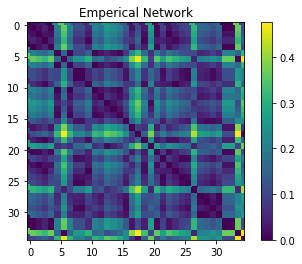

In [7]:
plot_matrix(dataset[2,0,:,:], 'Emperical Network')

In [36]:
def rewire_graph(G, num_swaps):
    """ Rewires the graph by randomly swapping edges to introduce noise. """
    edges = list(G.edges(data=True))
    for _ in range(num_swaps):
        # Randomly select two edges to swap their weights
        edge1, edge2 = random.sample(edges, 2)
        # Swap weights
        G[edge1[0]][edge1[1]]['weight'], G[edge2[0]][edge2[1]]['weight'] = \
            G[edge2[0]][edge2[1]]['weight'], G[edge1[0]][edge1[1]]['weight']
    return G

9.112707443540199
13.086196451338695
14.11493735330075
14.38790075453469
14.190123797490926


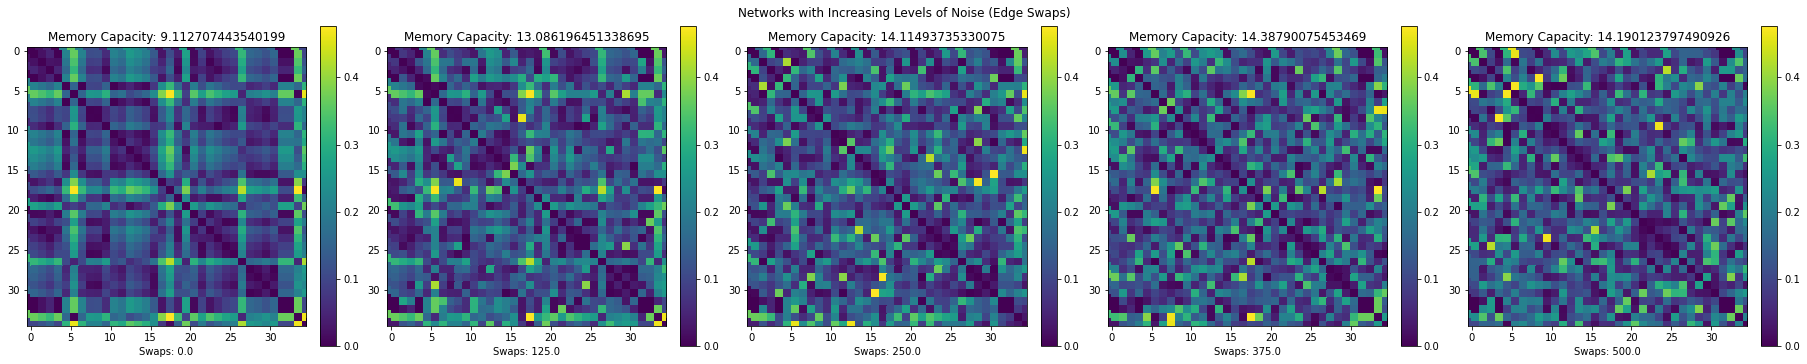

In [39]:
# Number of swaps for increasing noise levels
swap_counts = np.linspace(0, 500, 5)  # Adjust based on graph size and desired noise levels
memory_capacities_swap = np.zeros(swap_counts.shape)
matrices = np.zeros((swap_counts.shape[0], 35, 35))
# Visualizing the impact of increasing rewiring
for i, swaps in enumerate(swap_counts):
    # Create a copy of the original graph to rewire
    H = G.copy()
    H = rewire_graph(H, int(swaps))

    H_np = nx.to_numpy_array(H)
    
    #plot_matrix(H_np, f'Network with n={swaps} swaps')
    matrices[i] = H_np
    
    memory_capacities_swap[i] = compute_memory_capacity(H_np, X_train_val_np.reshape((-1, 1)), y_train_val_np, 
                                                         X_test_val_np.reshape((-1, 1)), y_test_val_np, max_lag)
    print(memory_capacities_swap[i])


n_graphs = len(matrices)
fig, axs = plt.subplots(1, n_graphs, figsize=(5 * n_graphs, 5), constrained_layout=True)
fig.suptitle('Networks with Increasing Levels of Noise (Edge Swaps)')

# Loop over the matrices and plot each one on a separate subplot
for i, (ax, matrix, memory_capacity, swap) in enumerate(zip(axs, matrices, memory_capacities_swap, swap_counts)):
    c = ax.pcolor(abs(matrix), cmap='viridis')  # Specify the colormap
    fig.colorbar(c, ax=ax)  # Associate the colorbar with the correct Axes
    ax.imshow(matrix, cmap='viridis')  # Specify the same colormap for imshow
    ax.set_title(f'Memory Capacity: {memory_capacity}')
    ax.set_xlabel(f'Swaps: {swap}')
    ax.xaxis.set_label_position('bottom') 

# Show the final composite figure
plt.show()

In [37]:
def rewire_to_density(G, target_density):
    N = len(G)
    current_edges = list(G.edges())
    possible_edges = list(nx.non_edges(G))
    current_num_edges = len(current_edges)
    max_edges = N * (N - 1) / 2
    target_num_edges = int(target_density * max_edges)

    # Adding or removing edges
    if current_num_edges < target_num_edges:
        # Add edges
        edges_to_add = target_num_edges - current_num_edges
        edges_added = 0
        while edges_added < edges_to_add and possible_edges:
            edge = random.choice(possible_edges)
            G.add_edge(*edge)
            possible_edges.remove(edge)
            edges_added += 1
    elif current_num_edges > target_num_edges:
        # Remove edges
        edges_to_remove = current_num_edges - target_num_edges
        edges_removed = 0
        while edges_removed < edges_to_remove and current_edges:
            edge = random.choice(current_edges)
            G.remove_edge(*edge)
            current_edges.remove(edge)
            possible_edges.append(edge)
            edges_removed += 1

    return G

The density of the graph is: 0.9899
9.112707443540199
The density of the graph is: 0.7412
14.950031398830257
The density of the graph is: 0.4941
17.860543895961673
The density of the graph is: 0.2471
20.949886010314515
The density of the graph is: 0.0000
0.0


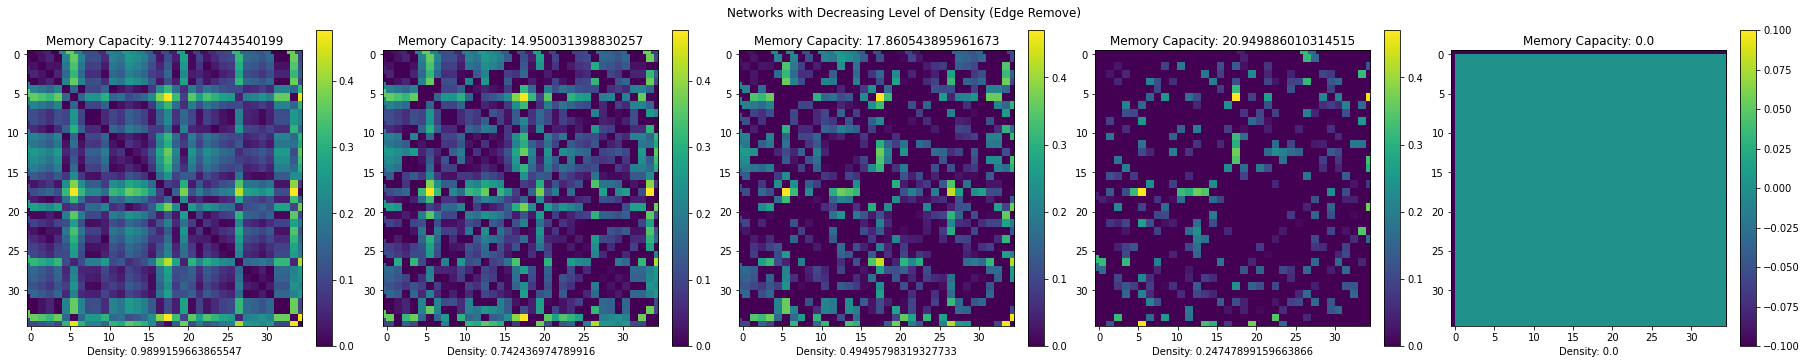

In [53]:
cur_density = nx.density(G)
densities = np.linspace(cur_density, 0, 5)
memory_capacities_density = np.zeros(densities.shape[0])
density_matrices = np.zeros((densities.shape[0], 35, 35))
G = nx.from_numpy_array(dataset[2,0,:,:])

for i, cur_density in enumerate(densities):
    # Create a copy of the original graph to rewire
    H = G.copy()
    H = rewire_to_density(H, cur_density)

    H_np = nx.to_numpy_array(H)
    new_density = nx.density(H)
    print(f"The density of the graph is: {new_density:.4f}")
    if new_density != 0:
        density_matrices[i] = H_np
        memory_capacities_density[i] = compute_memory_capacity(H_np, X_train_val_np.reshape((-1, 1)), y_train_val_np, 
                                                         X_test_val_np.reshape((-1, 1)), y_test_val_np, max_lag)
        
    print(memory_capacities_density[i])

n_graphs = len(density_matrices)
fig, axs = plt.subplots(1, n_graphs, figsize=(5 * n_graphs, 5), constrained_layout=True)
fig.suptitle('Networks with Decreasing Level of Density (Edge Remove)')

# Loop over the matrices and plot each one on a separate subplot
for i, (ax, matrix, memory_capacity, density) in enumerate(zip(axs, density_matrices, memory_capacities_density, densities)):
    c = ax.pcolor(abs(matrix), cmap='viridis')  # Specify the colormap
    fig.colorbar(c, ax=ax)  # Associate the colorbar with the correct Axes
    ax.imshow(matrix, cmap='viridis')  # Specify the same colormap for imshow
    ax.set_title(f'Memory Capacity: {memory_capacity}')
    ax.set_xlabel(f'Density: {density}')
    ax.xaxis.set_label_position('bottom') 

# Show the final composite figure
plt.show()

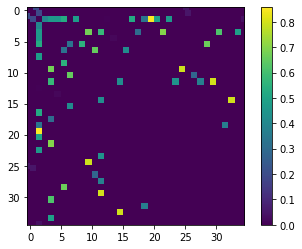

m value:1, mem cap: 18.638467465815115


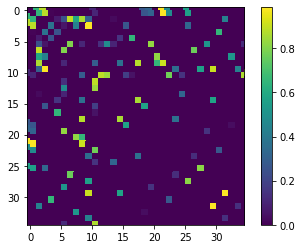

m value:2, mem cap: 23.086565651894965


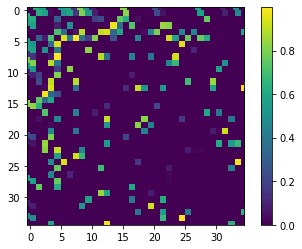

m value:3, mem cap: 22.152027347200548


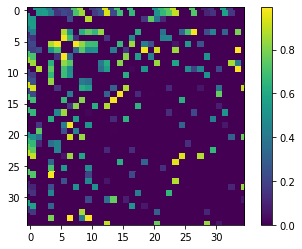

m value:4, mem cap: 20.061362584247554


In [29]:
# Parameters for the BA model
m_values = range(1, 5)  # Range of 'm' values to explore

# Store the generated graphs
ba_graphs = []

for m in m_values:
    G = nx.to_numpy_array(nx.barabasi_albert_graph(35, int(m)))
    G = make_und_weighted(G)
    plot_matrix(G, '')
    mem_cap = compute_memory_capacity(G.astype(np.float64), X_train_val_np.reshape((-1, 1)), y_train_val_np, 
                                      X_test_val_np.reshape((-1, 1)), y_test_val_np, max_lag)
    print(f'm value:{m}, mem cap: {mem_cap}')
    

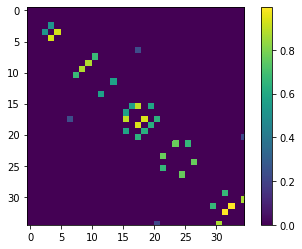

Intra-prob: 0.10, Inter-prob: 0.01, Mem Cap: 19.34172


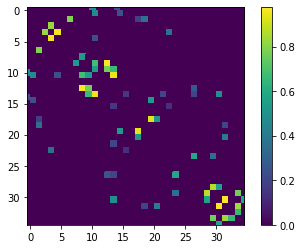

Intra-prob: 0.10, Inter-prob: 0.03, Mem Cap: 21.63724


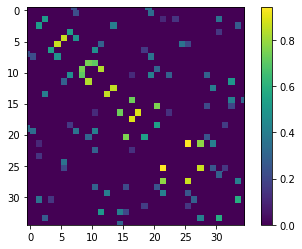

Intra-prob: 0.10, Inter-prob: 0.06, Mem Cap: 24.04581


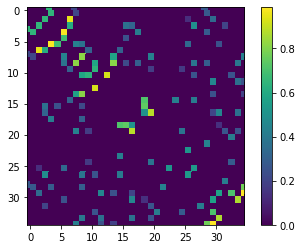

Intra-prob: 0.10, Inter-prob: 0.08, Mem Cap: 23.58673


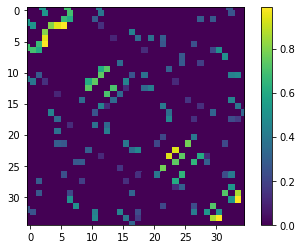

Intra-prob: 0.10, Inter-prob: 0.10, Mem Cap: 23.24990


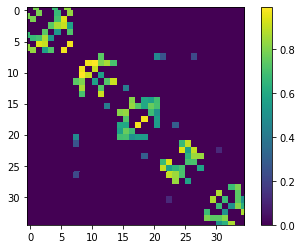

Intra-prob: 0.30, Inter-prob: 0.01, Mem Cap: 22.67657


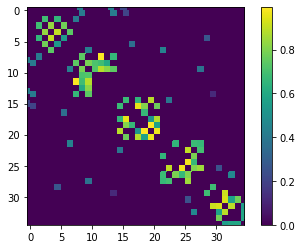

Intra-prob: 0.30, Inter-prob: 0.03, Mem Cap: 22.40322


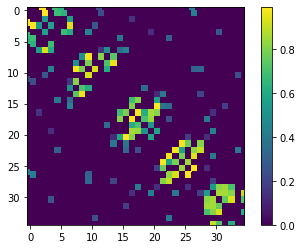

Intra-prob: 0.30, Inter-prob: 0.06, Mem Cap: 22.47428


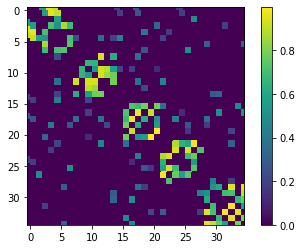

Intra-prob: 0.30, Inter-prob: 0.08, Mem Cap: 22.68242


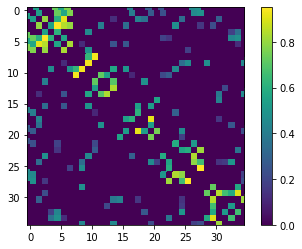

Intra-prob: 0.30, Inter-prob: 0.10, Mem Cap: 22.72579


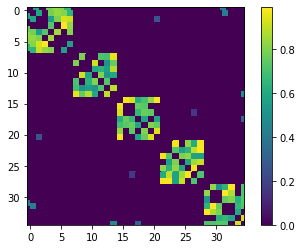

Intra-prob: 0.50, Inter-prob: 0.01, Mem Cap: 19.74274


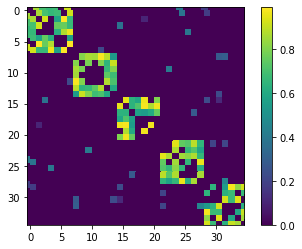

Intra-prob: 0.50, Inter-prob: 0.03, Mem Cap: 19.68576


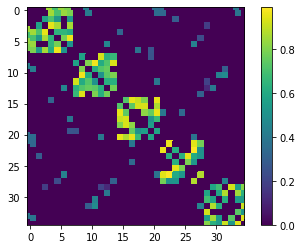

Intra-prob: 0.50, Inter-prob: 0.06, Mem Cap: 19.86095


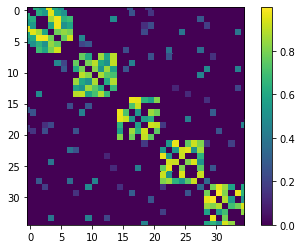

Intra-prob: 0.50, Inter-prob: 0.08, Mem Cap: 19.65157


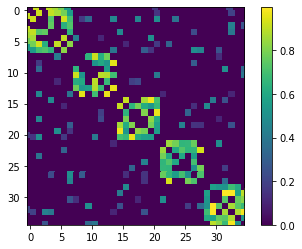

Intra-prob: 0.50, Inter-prob: 0.10, Mem Cap: 20.78081


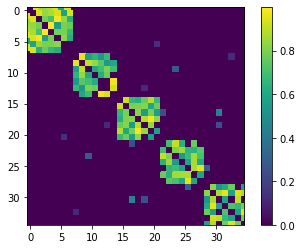

Intra-prob: 0.70, Inter-prob: 0.01, Mem Cap: 17.09526


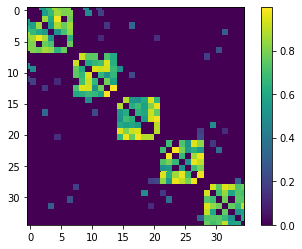

Intra-prob: 0.70, Inter-prob: 0.03, Mem Cap: 16.72703


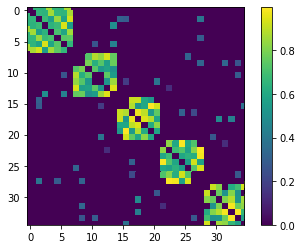

Intra-prob: 0.70, Inter-prob: 0.06, Mem Cap: 17.85337


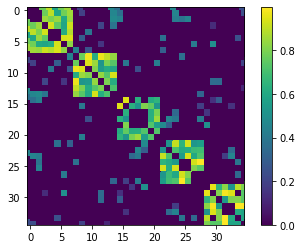

Intra-prob: 0.70, Inter-prob: 0.08, Mem Cap: 18.37490


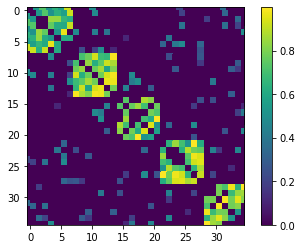

Intra-prob: 0.70, Inter-prob: 0.10, Mem Cap: 19.37706


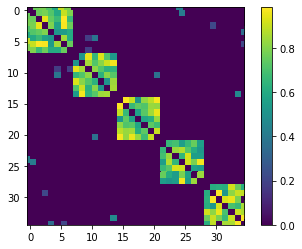

Intra-prob: 0.90, Inter-prob: 0.01, Mem Cap: 14.09242


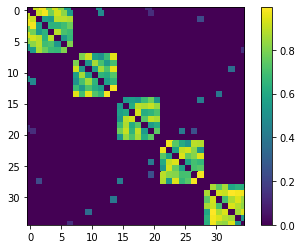

Intra-prob: 0.90, Inter-prob: 0.03, Mem Cap: 14.41188


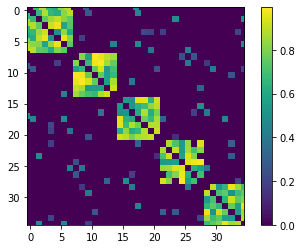

Intra-prob: 0.90, Inter-prob: 0.06, Mem Cap: 16.65620


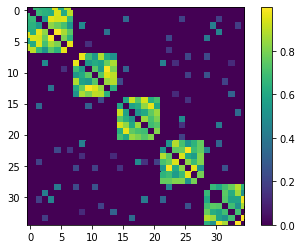

Intra-prob: 0.90, Inter-prob: 0.08, Mem Cap: 16.37901


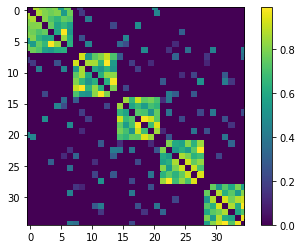

Intra-prob: 0.90, Inter-prob: 0.10, Mem Cap: 16.06682


In [38]:
def generate_weighted_modular_network(num_nodes=35, num_communities=5, intra_prob=0.7, inter_prob=0.01):
    """
    Generate a weighted modular network with specified intra-community and inter-community probabilities.
    
    :param num_nodes: Total number of nodes in the network.
    :param num_communities: Number of communities.
    :param intra_prob: Probability of intra-community edges.
    :param inter_prob: Probability of inter-community edges.
    :return: NetworkX graph object.
    """
    # Calculate the number of nodes per community
    nodes_per_community = num_nodes // num_communities
    
    # Initialize an empty graph
    G = nx.Graph()
    
    # Add nodes to the graph
    G.add_nodes_from(range(num_nodes))
    
    # Create intra-community edges
    for i in range(num_communities):
        community_nodes = range(i * nodes_per_community, (i + 1) * nodes_per_community)
        for u in community_nodes:
            for v in community_nodes:
                if u != v and np.random.rand() < intra_prob:
                    weight = np.random.uniform(0.5, 1.0)  # Assign a weight between 0.5 and 1.0
                    G.add_edge(u, v, weight=weight)
    
    # Create inter-community edges
    for i in range(num_communities):
        for j in range(i + 1, num_communities):
            community_i_nodes = range(i * nodes_per_community, (i + 1) * nodes_per_community)
            community_j_nodes = range(j * nodes_per_community, (j + 1) * nodes_per_community)
            for u in community_i_nodes:
                for v in community_j_nodes:
                    if np.random.rand() < inter_prob:
                        weight = np.random.uniform(0.1, 0.5)  # Assign a weight between 0.1 and 0.5
                        G.add_edge(u, v, weight=weight)
    
    return G

num_nodes = 35
size_per_module = 5
intra_module_p = 0.8  # High probability of connections within a module
inter_module_p = 0.05  # Low probability of connections between modules

for intra_prob in np.linspace(0.1, 0.9, 5):
    for inter_prob in np.linspace(0.01, 0.1, 5):
        G = generate_weighted_modular_network(intra_prob=intra_prob, inter_prob=inter_prob)
        modularity = nx.algorithms.community.quality.modularity(G, list(nx.algorithms.community.greedy_modularity_communities(G)))
        A_dense = nx.to_numpy_array(G, weight='weight')
        plot_matrix(A_dense, '')
        mem_cap = compute_memory_capacity(A_dense.astype(np.float64), X_train_val_np.reshape((-1, 1)), y_train_val_np, 
                                      X_test_val_np.reshape((-1, 1)), y_test_val_np, max_lag)
        print(f"Intra-prob: {intra_prob:.2f}, Inter-prob: {inter_prob:.2f}, Mem Cap: {mem_cap:.5f}")

# Correlation Experiment

In [39]:
import statistics
import scipy.stats as st
import pandas as pd
from scipy.stats import moment
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from bct.algorithms import(centrality, clustering, degree, distance, modularity, core, similarity, efficiency)

In [40]:
def compute_network_metrics(G):
    ci = np.arange(len(G)) + 1
    G_nx = nx.from_numpy_array(G)
    
    spectral_radius = max(np.abs(np.linalg.eigvals(G)))
    mean_node_strength = statistics.mean(degree.strengths_und(G))
    p = centrality.participation_coef(G, ci)
    avg_p = statistics.mean(p)
    d_pos, _ = centrality.diversity_coef_sign(G, ci)
    mean_d_pos = statistics.mean(d_pos)
    global_eff = efficiency.efficiency_wei(G)
    mean_betweenness_centrality = statistics.mean(centrality.betweenness_wei(G))
    mean_eigenv_centrality = statistics.mean(centrality.eigenvector_centrality_und(G))
    communities = nx.algorithms.community.greedy_modularity_communities(G_nx)
    modularity = nx.algorithms.community.quality.modularity(G_nx, list(nx.algorithms.community.greedy_modularity_communities(G_nx)))
    density = nx.density(G_nx)
    c = clustering.transitivity_wu(G)
    
    metrics = {
        'node_strength': mean_node_strength,
        'participation_coef': avg_p,
        'diversity_pos': mean_d_pos,
        'betweenness_centrality': mean_betweenness_centrality,
        'eigenvector_centrality': mean_eigenv_centrality,
        'global_efficiency': global_eff,
        'modularity': modularity,
        'density': density,
        'clustering': c,
        'spectral_radius': spectral_radius,
    }
    
    return metrics

p value:0.1, mem cap: 22.262795580782907


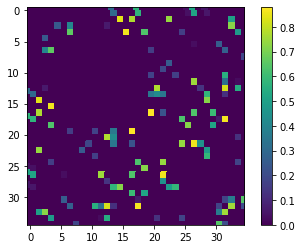

p value:0.2, mem cap: 22.325436911122758


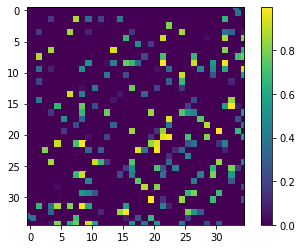

p value:0.30000000000000004, mem cap: 22.440558770835292


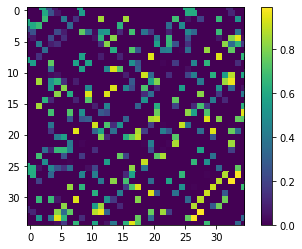

p value:0.4, mem cap: 19.408862739652324


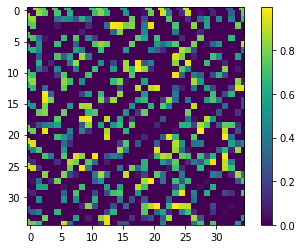

p value:0.5, mem cap: 19.087837123106894


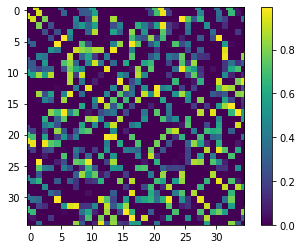

p value:0.6, mem cap: 17.13793056927295


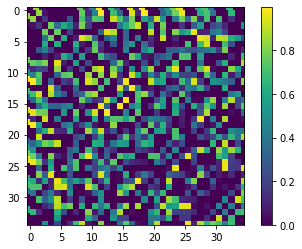

p value:0.7000000000000001, mem cap: 16.09008974972246


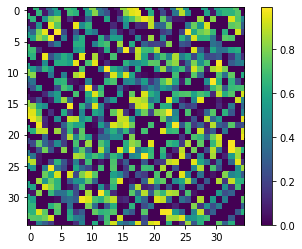

p value:0.8, mem cap: 15.093806286812075


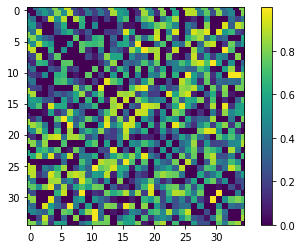

p value:0.9, mem cap: 14.995600272676226


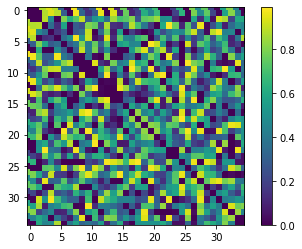

In [23]:
p_values = np.arange(0.1, 1, 0.1)
for p in p_values:
    G = nx.to_numpy_array(nx.fast_gnp_random_graph(p=p, directed=False, n=35))
    G = make_und_weighted(G)
    mem_cap = compute_memory_capacity(G.astype(np.float64), X_train_val_np.reshape((-1, 1)), y_train_val_np, 
                                      X_test_val_np.reshape((-1, 1)), y_test_val_np, max_lag)
    print(f'p value:{p}, mem cap: {mem_cap}')
    plot_matrix(G, '')

In [41]:
def get_real_graphs(dataset):
    graphs = []
    for n_subject in range(dataset.shape[0]):
        for n_t in range(dataset.shape[1]):
            graph = dataset[n_subject, n_t, :, :]
            graphs.append(graph)
            
    return graphs

def get_rewired_graphs(dataset, swap_counts):
    rewired_graphs = []
    for n_subject in range(dataset.shape[0]):
        for n_t in range(dataset.shape[1]):
            graph = dataset[n_subject, n_t, :, :]
    
            for swaps in swap_counts:
                H = nx.from_numpy_array(graph)
                H = rewire_graph(H, int(swaps))
                rewired_graph = nx.to_numpy_array(H)
                rewired_graphs.append(rewired_graph)

    return rewired_graphs
    
def get_edge_removed_graphs(dataset, densities):
    edge_removed_graphs = []
    for n_subject in range(dataset.shape[0]):
        for n_t in range(dataset.shape[1]):
            graph = dataset[n_subject, n_t, :, :]
    
            for density in densities:
                H = nx.from_numpy_array(graph)
                H = rewire_to_density(H, density)
                edge_removed_graph = nx.to_numpy_array(H)
                edge_removed_graphs.append(edge_removed_graph)
                
    return edge_removed_graphs

def make_und_weighted(G):
    G = G * np.random.uniform(0, 1, G.shape)
    G[np.where(abs(G) <= 0.00001)] = 0

    upper_diag = G.copy()[np.triu_indices_from(G, 1)]
    G = G.T
    G[np.triu_indices_from(G, 1)] = upper_diag
    np.fill_diagonal(G,0)

    return G

def get_erdos_renyi(n, p_values):
    graphs = []
    for _ in range(300):
        for p in p_values:
            G = nx.to_numpy_array(nx.fast_gnp_random_graph(p=p, directed=False, n=n))
            G = make_und_weighted(G)
            graphs.append(G)
    return graphs

def get_barabasi_albert(n, m_values):
    graphs = []
    for _ in range(200):
        for m in m_values:
            G = nx.to_numpy_array(nx.barabasi_albert_graph(n, int(m)))
            G = make_und_weighted(G)
            graphs.append(G)
    return graphs
    
def get_modular_network():
    graphs = []
    for _ in range(150):
        for intra_prob in np.linspace(0.1, 0.9, 5):
            for inter_prob in np.linspace(0.01, 0.1, 5):
                G = generate_weighted_modular_network(intra_prob=intra_prob, inter_prob=inter_prob)
                graphs.append(nx.to_numpy_array(G, weight='weight'))
    return graphs

In [42]:
def get_nets_metrics_and_mem(nets):
    X, y = [], []
    for G in nets:
        metrics = compute_network_metrics(G)
        X.append(np.array(list(metrics.values())))
        y.append(compute_memory_capacity(G.astype(np.float64), X_train_val_np.reshape((-1, 1)), y_train_val_np, 
                                      X_test_val_np.reshape((-1, 1)), y_test_val_np, max_lag))
    return np.array(X), np.array(y)

In [49]:
real_brain_networks = get_real_graphs(dataset)
X_real_brain, y_real_brain = get_nets_metrics_and_mem(real_brain_networks)

In [57]:
disrupted_real_brain_networks = get_rewired_graphs(dataset, np.linspace(100, 300, 3)) + get_edge_removed_graphs(dataset, np.linspace(0.98, 0.1, 6))
X_disrupted_brain, y_disrupted_brain = get_nets_metrics_and_mem(disrupted_real_brain_networks)

/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbu

In [44]:
erdos_renyi_networks = get_erdos_renyi(35, np.arange(0.1, 0.9, 0.1))
X_erdos_renyi_networks, y_erdos_renyi_networks = get_nets_metrics_and_mem(erdos_renyi_networks)

/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbu

In [45]:
barabasi_albert_networks = get_barabasi_albert(35, range(1, 15))
X_barabasi_albert_networks, y_barabasi_albert_networks = get_nets_metrics_and_mem(barabasi_albert_networks)

In [46]:
modular_networks = get_modular_network()
X_modular_networks, y_modular_networks = get_nets_metrics_and_mem(modular_networks)

/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbucket/sx420/miniconda3/envs/test/lib/python3.8/site-packages/bct/algorithms/centrality.py:786: RuntimeWarning: invalid value encountered in divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)
/vol/bitbu

In [47]:
def plot_distributions_and_save(X, y, file_name):
    print(X.shape)
    keys = ['node_strength', 'participation_coef', 'diversity_pos', 'betweenness_centrality', 'eigenvector_centrality', 'global_efficiency', 'modularity', 'density','clustering',
'spectral_radius']
    result_dict = {key: [data[i] for data in X] for i, key in enumerate(keys)}
    df = pd.DataFrame(result_dict)
    
    # Set aesthetic parameters in one step
    sns.set(style="whitegrid")
    
    # Histograms for each column except 'memory_capacity'
    df.hist(bins=50, figsize=(15, 10))
    plt.show()
    df['memory_capacity'] = y
    df.to_csv(file_name, index=False)
    

(339, 10)


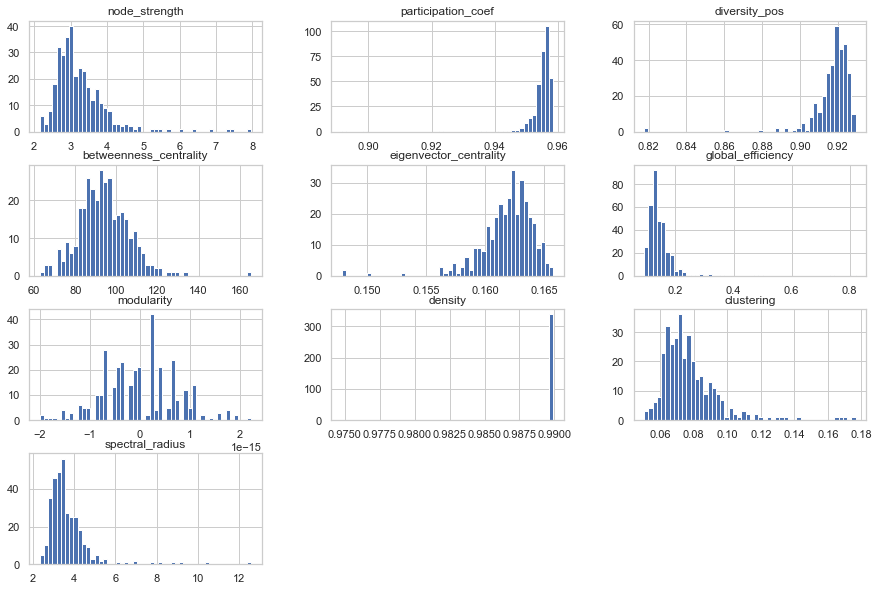

In [50]:
plot_distributions_and_save(X_real_brain, y_real_brain, 'real_brain_graph.csv')

(3051, 10)


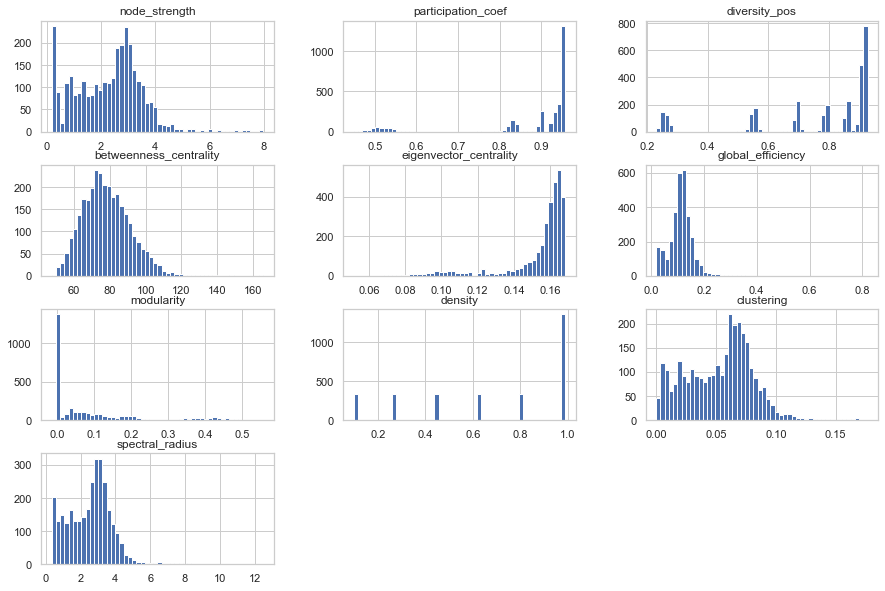

In [71]:
plot_distributions_and_save(X_disrupted_brain, y_disrupted_brain, 'disrupted_brain_graph.csv')

(2400, 10)


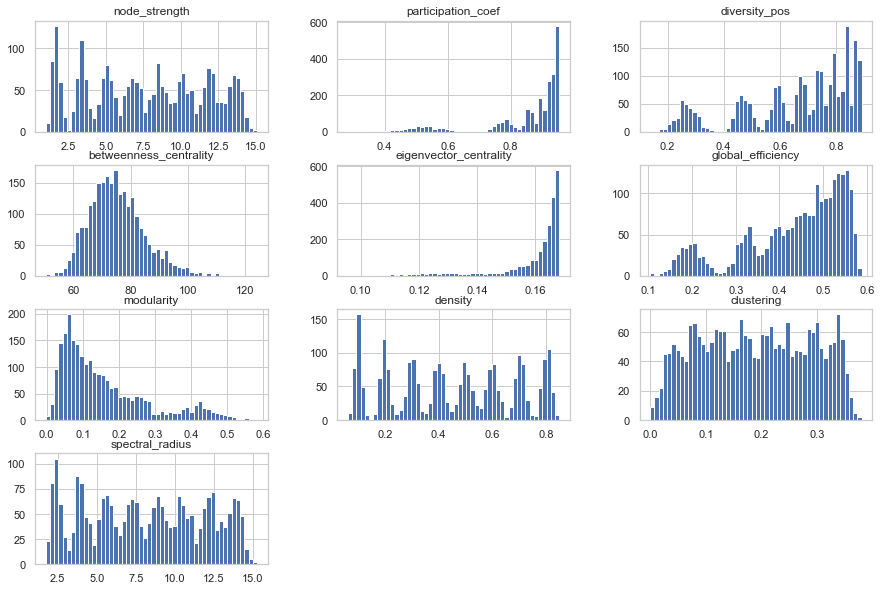

In [52]:
plot_distributions_and_save(X_erdos_renyi_networks, y_erdos_renyi_networks, 'erdos_renyi_graph.csv')

(2800, 10)


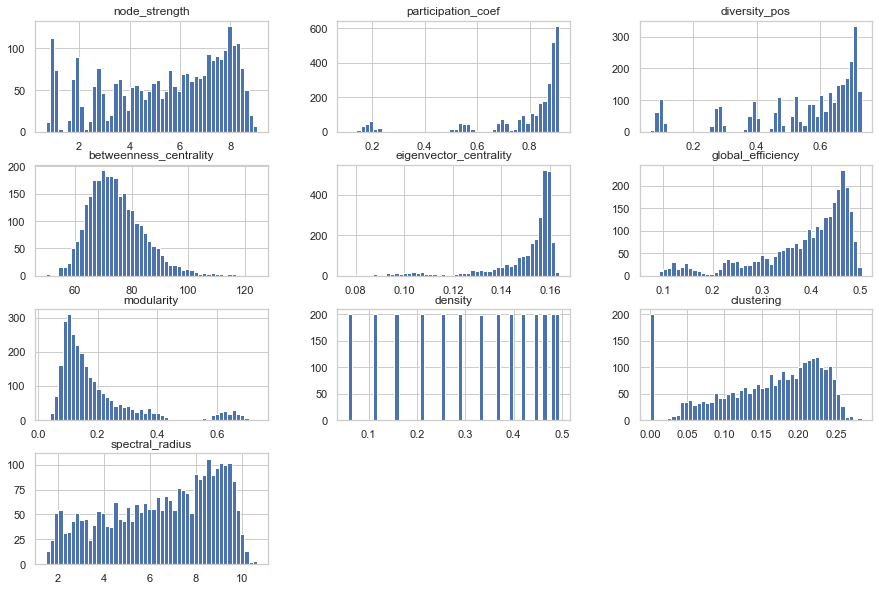

In [53]:
plot_distributions_and_save(X_barabasi_albert_networks, y_barabasi_albert_networks, 'barabasi_albert_networks.csv')

(3750, 10)


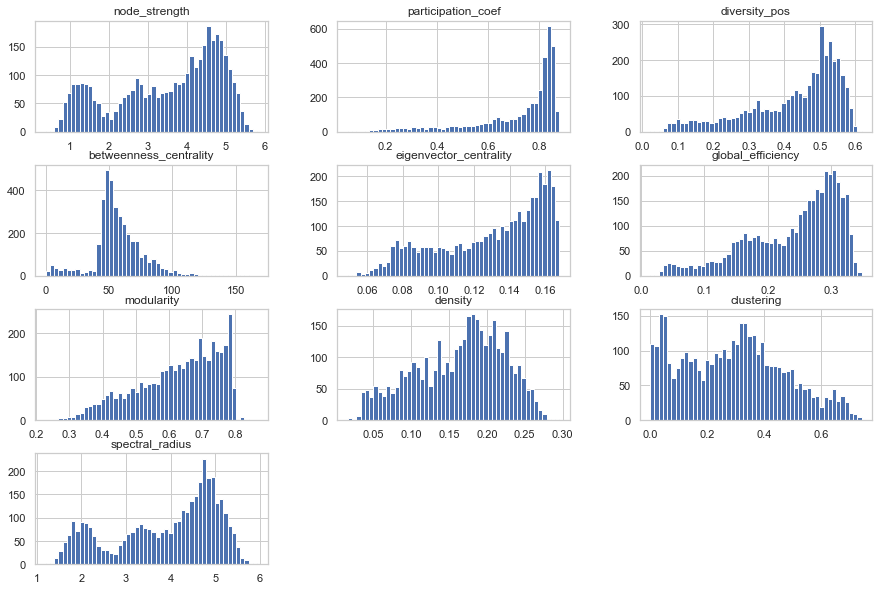

In [54]:
plot_distributions_and_save(X_modular_networks, y_modular_networks, 'modular_networks.csv')

In [59]:
X_total = np.vstack((X_real_brain, X_disrupted_brain, X_erdos_renyi_networks, X_barabasi_albert_networks, X_modular_networks))
y_total = np.concatenate((y_real_brain, y_disrupted_brain, y_erdos_renyi_networks, y_barabasi_albert_networks, y_modular_networks))

(12340, 10)


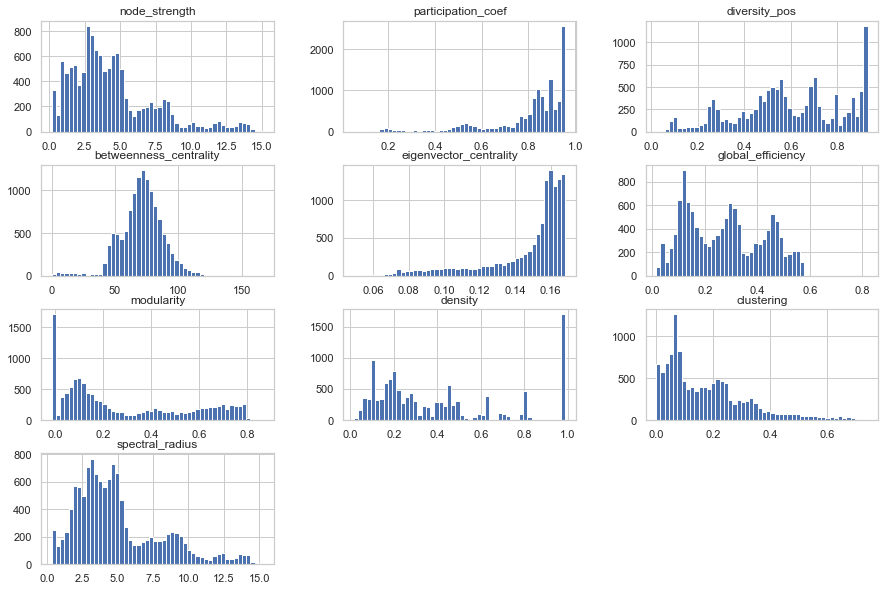

In [72]:
plot_distributions_and_save(X_total, y_total, 'all_networks.csv')

In [73]:
def train_model(X, y):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create a Linear Regression model
    model = LinearRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict the memory capacity on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    print(f'R^2 Score: {r2}')

In [74]:
train_model(X_total, y_total)

R^2 Score: 0.8937837535913745


In [75]:
train_model(X_real_brain, y_real_brain)

R^2 Score: 0.07886031752425726


In [76]:
train_model(X_disrupted_brain, y_disrupted_brain)

R^2 Score: 0.9300814440672721


In [77]:
train_model(X_erdos_renyi_networks, y_erdos_renyi_networks)

R^2 Score: 0.9882655244856575


In [78]:
train_model(X_barabasi_albert_networks, y_barabasi_albert_networks)

R^2 Score: 0.9104402468446506


In [79]:
train_model(X_modular_networks, y_modular_networks)

R^2 Score: 0.9334497378040749


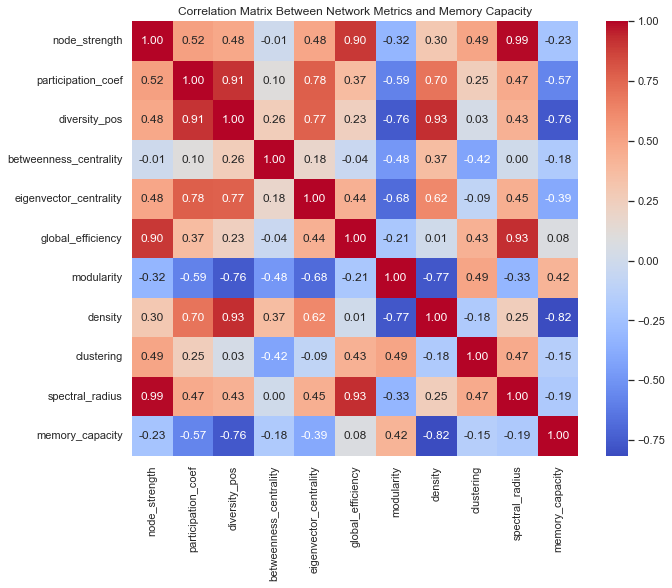

In [80]:
metrics_df = pd.read_csv('all_networks.csv')

# Compute the correlation matrix
corr_matrix = metrics_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Between Network Metrics and Memory Capacity')
plt.show()

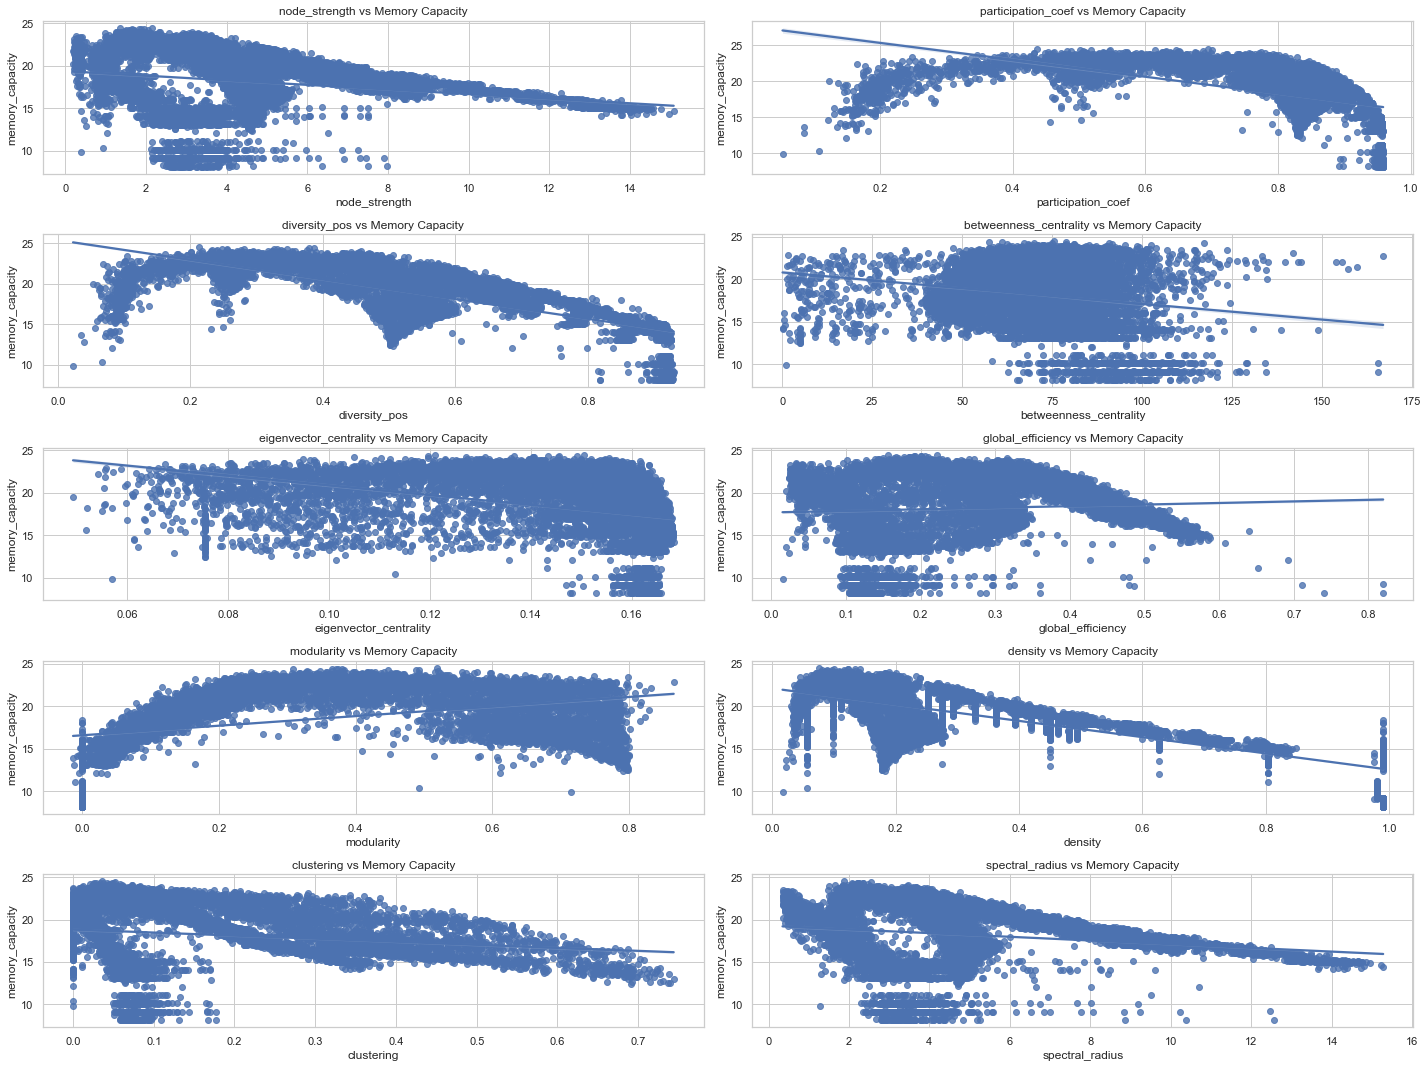

In [69]:
keys = ['node_strength', 'participation_coef', 'diversity_pos', 'betweenness_centrality', 'eigenvector_centrality', 'global_efficiency', 'modularity', 'density', 'clustering',
'spectral_radius']
plt.figure(figsize=(20, 15))
for i, metric in enumerate(keys, 1):
    plt.subplot(5, 2, i)
    sns.regplot(x=metric, y='memory_capacity', data=metrics_df)
    plt.title(f'{metric} vs Memory Capacity')
plt.tight_layout()
plt.show()

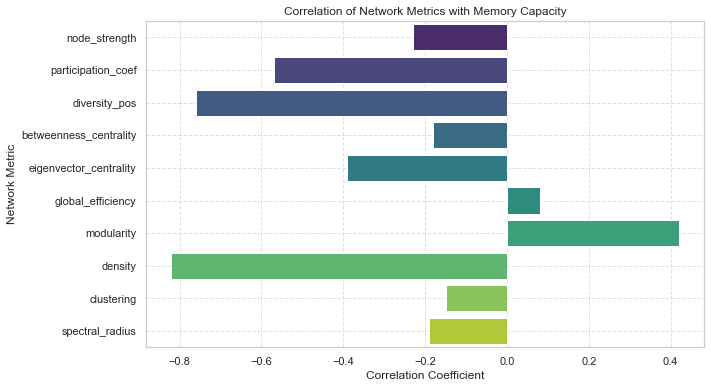

In [83]:
correlation_data = {
    'node_strength': -0.23,
    'participation_coef': -0.57,
    'diversity_pos': -0.76,
    'betweenness_centrality': -0.18,
    'eigenvector_centrality': -0.39,
    'global_efficiency': 0.08,
    'modularity': 0.42,
    'density': -0.82,
    'clustering': -0.15,
    'spectral_radius': -0.19
}

# Convert the dictionary to a DataFrame for easier plotting
df = pd.DataFrame(list(correlation_data.items()), columns=['Metric', 'Correlation with Memory Capacity'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation with Memory Capacity', y='Metric', hue='Metric', data=df, palette='viridis')
plt.title('Correlation of Network Metrics with Memory Capacity')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Network Metric')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()